In [41]:
!pip install pandas

!pip install seaborn
!pip install numpy

!pip install matplotlib

!pip install scikit-learn

In [1]:
import matplotlib.pyplot as plt

import matplotlib

import seaborn as sns

import numpy as np

import pandas as pd

from sklearn import neighbors, metrics

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder

from collections import Counter

import re

from sklearn.covariance import EllipticEnvelope

from sklearn.linear_model import LinearRegression

from sklearn.naive_bayes import GaussianNB

from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import cross_val_score


data = pd.read_csv("BankChurners.csv")

clientnum_data = data["CLIENTNUM"].copy()

data = data.drop(["CLIENTNUM"], axis=1)

origin_data = data.copy()



In [3]:
def handle_outliers(feature_data: pd.core.frame.DataFrame, placeholder_val: float = None,
                    method: str = "statistic_quantiles",
                    method_koef: float = 0.95,
                    placeholder_type: str = "quantile"):
    '''

    :param feature_data:
    :param placeholder_val:
    :param method: available methods: "statistic_quantiles", "elliptic_envelope"
    :param method_koef: coefficient that depends on method
    :param placeholder_type: available placeholder types:
    "own": placeholder_val have to contain value of your own placeholder;
    "quantile": placeholder_val have to contain percent coefficient for quantile,
    that replaces placeholder_val with it's value
    :return: (feature_data, outlier_data), feature_data - feature data with processed outlier values;
    outlier_data - outlier values that was chose by :param method:
    '''
    feature_data = feature_data.copy()
    manage_array :np.array # (10127, 1)
    if method == "statistic_quantiles":
        if method_koef > 0.5:
            manage_array = feature_data > feature_data.quantile(q=method_koef)
        else:
            manage_array = feature_data < feature_data.quantile(q=method_koef)
    elif method == "elliptic_envelope":
        outlier = EllipticEnvelope(contamination=method_koef)
        x = feature_data.values.reshape(-1, 1)
        outlier.fit(x)
        res = outlier.predict(x)
        manage_array = [True if i == -1 else False for i in res]

    outlier_data = feature_data[manage_array]
    # print(len(outlier_data))
    if placeholder_type != "own":
        if placeholder_type == "quantile":
            placeholder_val = feature_data.quantile(placeholder_val)

    if placeholder_type != "False":
        feature_data[manage_array] = placeholder_val
    # print(feature_data)
    # print(manage_array)
    return feature_data, outlier_data

def identify_data_type(dataset: pd.core.frame.DataFrame):
    features_list = list(dataset.columns)
    features_types_dict = {"Categorical": [], "Numerical": []}
    for feature_name in features_list:
        if any([type_i in data[feature_name].dtype.name
                for type_i in ["int", "object"]]):
            features_types_dict["Categorical"].append(feature_name)
        elif "float" in data[feature_name].dtype.name:
            features_types_dict["Numerical"].append(feature_name)
    return features_types_dict

# data type identifying

In [4]:
features_types = identify_data_type(dataset=data)
numerical_features = features_types["Numerical"]

numerical_features += ["Total_Trans_Ct", "Total_Revolving_Bal",
                       "Total_Trans_Amt", "Customer_Age", "Months_on_book"]
features_types["Categorical"].remove("Customer_Age")
features_types["Categorical"].remove("Total_Trans_Ct")
features_types["Categorical"].remove("Total_Revolving_Bal")
features_types["Categorical"].remove("Total_Trans_Amt")
features_types["Categorical"].remove("Months_on_book")

ordinal_features = ["Dependent_count", "Education_Level", "Card_Category",
                "Income_Category", "Total_Relationship_Count",
                "Months_Inactive_12_mon", "Contacts_Count_12_mon"]
categorical_features = [i for i in features_types["Categorical"] if i not in ordinal_features]

In [51]:
numerical_features

['Credit_Limit',
 'Avg_Open_To_Buy',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio',
 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2',
 'Total_Trans_Ct',
 'Total_Revolving_Bal',
 'Total_Trans_Amt',
 'Customer_Age',
 'Months_on_book']

# dataset pre-processing

In [232]:
#return origin numeric features
data[numerical_features] = origin_data[numerical_features]

outliers handling

In [5]:
# x = data[numerical_features[1]].values.reshape(-1, 1)
#
# outlier = EllipticEnvelope(contamination=0.1)
# outlier.fit(x)
# res = outlier.predict(x)
#
# a=[False if i != -1 else True for idx, i in enumerate(res)]
# data[numerical_features[1]][a] = 1
numerical_features_outliers = dict()
for feature in numerical_features:
    if not feature.startswith("Naive_Bayes_Classifier_"):
        data[feature], out = handle_outliers(feature_data=data[feature],
                                             method="statistic_quantiles", method_koef=0.999901244321,
                                             placeholder_type="False")
        numerical_features_outliers[feature] = out
        print("outliers number",len(out.keys()))
        data = data.drop(out.keys(), axis=0)
# numerical_features_outliers
data

outliers number 0
outliers number 0
outliers number 2
outliers number 1
outliers number 1
outliers number 1
outliers number 0
outliers number 1
outliers number 1
outliers number 0


,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.999910
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.999980
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.999870
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.999980
5,Existing Customer,44,M,2,Graduate,Married,$40K - $60K,Blue,36,3,...,4010.0,1247,2763.0,1.376,1088,24,0.846,0.311,0.000055,0.999940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,3,...,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462,0.000191,0.999810
10123,Attrited Customer,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,4,...,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511,0.995270,0.004729
10124,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,5,...,5409.0,0,5409.0,0.819,10291,60,0.818,0.000,0.997880,0.002118
10125,Attrited Customer,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,4,...,5281.0,0,5281.0,0.535,8395,62,0.722,0.000,0.996710,0.003294


In [ ]:
[len(i) for i in numerical_features_outliers.values()]
len(data[numerical_features[1]].values)

# scatter plots for numerical features

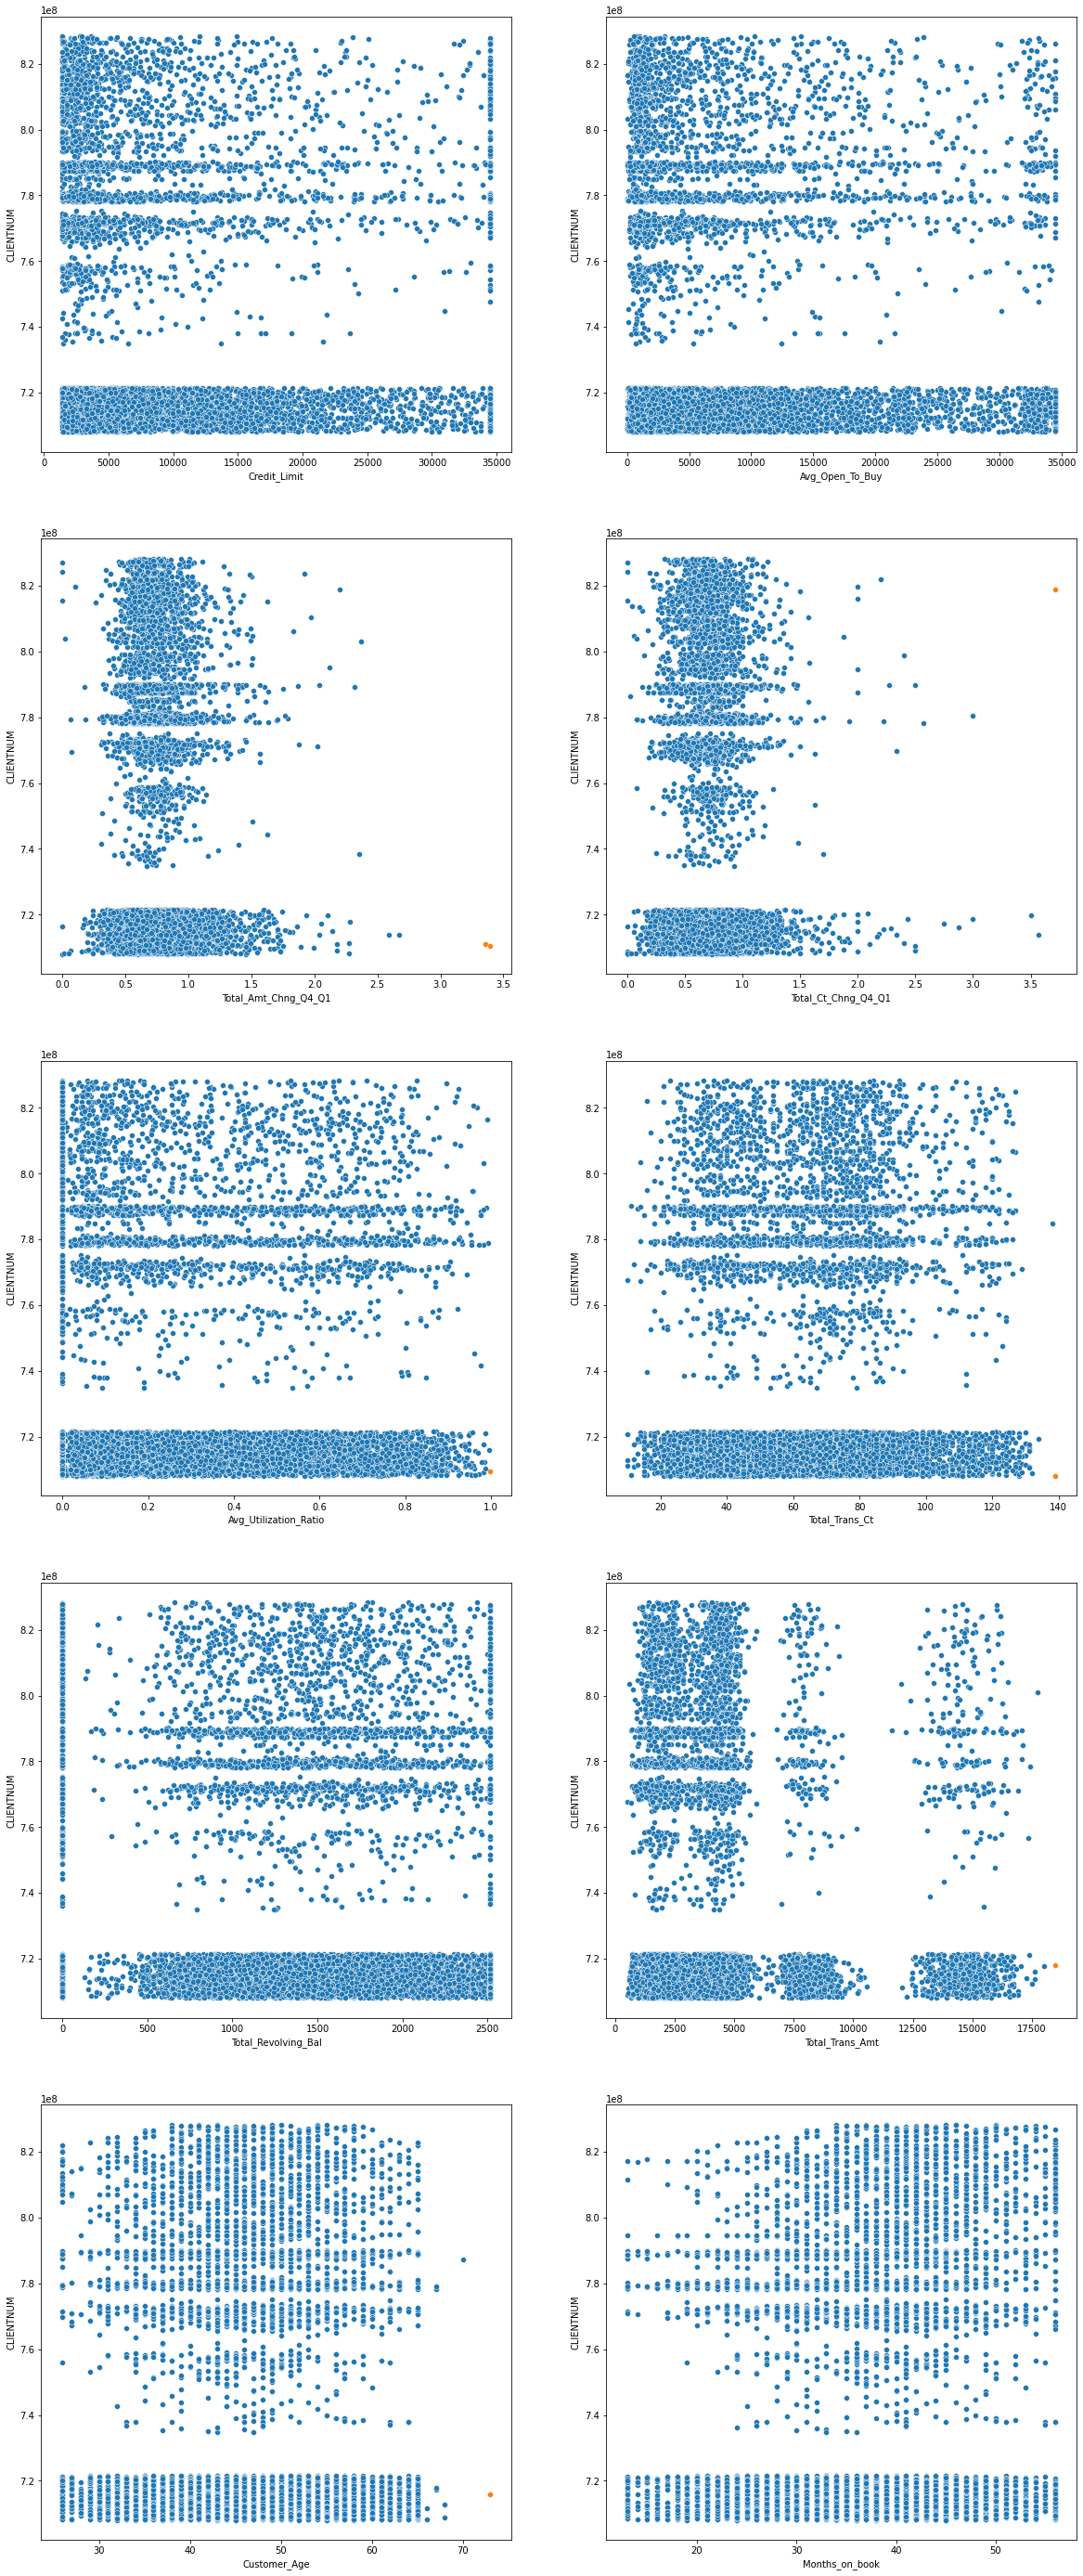

In [11]:
fig, axes = plt.subplots(5, 2, figsize=(20,50))
axes = [graph for line in axes for graph in line]
for idx, feature in enumerate(data[[i
                              for i in numerical_features if not i.startswith("Naive_Bayes_Classifier_")]]):
    if not feature.startswith("Naive_Bayes_Classifier_"):
        sns.scatterplot(x=data[feature], y=clientnum_data, ax=axes[idx])
        sns.scatterplot(x=numerical_features_outliers[feature],
                        y=clientnum_data[numerical_features_outliers[feature].keys()], ax=axes[idx])

In [25]:
data
# pd.concat([data["Gender"].iloc[0:30], data["Gender"].iloc[49:69]], axis=0).keys()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.999910
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.999980
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.999870
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.999980
5,Existing Customer,44,M,2,Graduate,Married,$40K - $60K,Blue,36,3,...,4010.0,1247,2763.0,1.376,1088,24,0.846,0.311,0.000055,0.999940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,3,...,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462,0.000191,0.999810
10123,Attrited Customer,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,4,...,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511,0.995270,0.004729
10124,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,5,...,5409.0,0,5409.0,0.819,10291,60,0.818,0.000,0.997880,0.002118
10125,Attrited Customer,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,4,...,5281.0,0,5281.0,0.535,8395,62,0.722,0.000,0.996710,0.003294


# non-numeric -> numeric

In [6]:
print("Attrition_Flag\n")
# Le = LabelEncoder()
# data["Attrition_Flag"] = Le.fit_transform(data["Attrition_Flag"].values)
data["Attrition_Flag"] = data["Attrition_Flag"].map({"Attrited Customer": 1,
                                                     "Existing Customer": 0})
data["Attrition_Flag"]

print("Gender\n")
Le = LabelEncoder()
data["Gender"] = Le.fit_transform(data["Gender"].values)
data["Gender"]

print("Marital_Status\n")
# data["Marital_Status"][data["Marital_Status"] == "Unknown"] = float("nan")

# modified_marital_status = pd.get_dummies(data["Marital_Status"],
#                                          prefix="Marital_Status").drop("Marital_Status_Unknown", axis=1)
# modified_marital_status.iloc[(modified_marital_status.sum(axis=1) == 0).values, :] = float("nan")
# data = data.drop("Marital_Status", axis=1)
# data = pd.concat([data, modified_marital_status], axis=1)

marital_status_map = {'Married': 2, 'Single': 1, 'Divorced': 3}
data["Marital_Status"] = data["Marital_Status"].map(marital_status_map)

print("Income_Category\n")
mean_bin_length = (20 + 20 + 40) / 3
Income_Category_map = {'$60K - $80K': (60 + 80) / 2,
                       'Less than $40K': ((40 - mean_bin_length) + 40) / 2,
                       '$80K - $120K': (80 + 120) / 2, '$40K - $60K':(40 + 60) / 2,
                       '$120K +': (120 + (120 + mean_bin_length)) / 2}
data.Income_Category = data.Income_Category.map(Income_Category_map)

print("Education_Level\n")
education_level_map = {"Uneducated": 1, "High School": 2, "College": 3, "Graduate": 4,
                       "Post-Graduate": 5, "Doctorate": 6}
data.Education_Level = data["Education_Level"].map(education_level_map)

print("Card_Category\n")
card_category_map = {"Blue": 1, "Gold": 2, "Silver": 3, "Platinum": 4}
data.Card_Category = data["Card_Category"].map(card_category_map)


Attrition_Flag

Gender

Marital_Status

Income_Category

Education_Level

Card_Category



# END of main part non-numeric -> numeric

In [18]:
data
# data["Attrition_Flag"].value_counts()

0    8494
1    1626
Name: Attrition_Flag, dtype: int64

Marital_Status

In [ ]:
# data["Marital_Status"][data["Marital_Status"] == "Unknown"] = float("nan")

# modified_marital_status = pd.get_dummies(data["Marital_Status"],
#                                          prefix="Marital_Status").drop("Marital_Status_Unknown", axis=1)
# modified_marital_status.iloc[(modified_marital_status.sum(axis=1) == 0).values, :] = float("nan")
# data = data.drop("Marital_Status", axis=1)
# data = pd.concat([data, modified_marital_status], axis=1)

marital_status_map = {'Married': 2, 'Single': 1, 'Divorced': 3}
data["Marital_Status"] = data["Marital_Status"].map(marital_status_map)

In [178]:
data

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,1,45.0,1,3,NaN,NaN,NaN,NaN,39,5,...,12691.0,777,11914.0,1.335,1144.0,42.0,1.625,0.061,0.000093,0.999910
1,1,49.0,0,5,NaN,NaN,NaN,NaN,44,6,...,8256.0,864,7392.0,1.541,1291.0,33.0,NaN,0.105,0.000057,0.999940
2,1,51.0,1,3,NaN,NaN,NaN,NaN,36,4,...,3418.0,0,3418.0,2.594,1887.0,20.0,2.333,0.000,0.000021,0.999980
3,1,40.0,0,4,NaN,NaN,NaN,NaN,34,3,...,3313.0,2517,796.0,1.405,1171.0,20.0,2.333,0.760,0.000134,0.999870
4,1,40.0,1,3,NaN,NaN,NaN,NaN,21,5,...,4716.0,0,4716.0,2.175,816.0,28.0,2.500,0.000,0.000022,0.999980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,1,50.0,1,2,NaN,NaN,NaN,NaN,40,3,...,4003.0,1851,2152.0,0.703,15476.0,117.0,0.857,0.462,0.000191,0.999810
10123,0,41.0,1,2,NaN,NaN,NaN,NaN,25,4,...,4277.0,2186,2091.0,0.804,8764.0,69.0,0.683,0.511,0.995270,0.004729
10124,0,44.0,0,1,NaN,NaN,NaN,NaN,36,5,...,5409.0,0,5409.0,0.819,10291.0,60.0,0.818,0.000,0.997880,0.002118
10125,0,30.0,1,2,NaN,NaN,NaN,NaN,36,4,...,5281.0,0,5281.0,0.535,8395.0,62.0,0.722,0.000,0.996710,0.003294


Income_Category


In [ ]:
mean_bin_length = (20 + 20 + 40) / 3
Income_Category_map = {'$60K - $80K': (60 + 80) / 2,
                       'Less than $40K': ((40 - mean_bin_length) + 40) / 2,
                       '$80K - $120K': (80 + 120) / 2, '$40K - $60K':(40 + 60) / 2,
                       '$120K +': (120 + (120 + mean_bin_length)) / 2}
data.Income_Category = data.Income_Category.map(Income_Category_map)

In [183]:
data

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,1,45.0,1,3,2.0,2.0,70.000000,1,39,5,...,12691.0,777,11914.0,1.335,1144.0,42.0,1.625,0.061,0.000093,0.999910
1,1,49.0,0,5,4.0,1.0,26.666667,1,44,6,...,8256.0,864,7392.0,1.541,1291.0,33.0,NaN,0.105,0.000057,0.999940
2,1,51.0,1,3,4.0,2.0,100.000000,1,36,4,...,3418.0,0,3418.0,2.594,1887.0,20.0,2.333,0.000,0.000021,0.999980
3,1,40.0,0,4,2.0,NaN,26.666667,1,34,3,...,3313.0,2517,796.0,1.405,1171.0,20.0,2.333,0.760,0.000134,0.999870
4,1,40.0,1,3,1.0,2.0,70.000000,1,21,5,...,4716.0,0,4716.0,2.175,816.0,28.0,2.500,0.000,0.000022,0.999980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,1,50.0,1,2,4.0,1.0,50.000000,1,40,3,...,4003.0,1851,2152.0,0.703,15476.0,117.0,0.857,0.462,0.000191,0.999810
10123,0,41.0,1,2,NaN,3.0,50.000000,1,25,4,...,4277.0,2186,2091.0,0.804,8764.0,69.0,0.683,0.511,0.995270,0.004729
10124,0,44.0,0,1,2.0,2.0,26.666667,1,36,5,...,5409.0,0,5409.0,0.819,10291.0,60.0,0.818,0.000,0.997880,0.002118
10125,0,30.0,1,2,4.0,NaN,50.000000,1,36,4,...,5281.0,0,5281.0,0.535,8395.0,62.0,0.722,0.000,0.996710,0.003294


Education_Level

In [ ]:
education_level_map = {"Uneducated": 1, "High School": 2, "College": 3, "Graduate": 4,
                       "Post-Graduate": 5, "Doctorate": 6}
data.Education_Level = data["Education_Level"].map(education_level_map)

In [3]:
data[data.Education_Level.isnull()]

NameError: name 'data' is not defined

Card_Category

In [ ]:
card_category_map = {"Blue": 1, "Gold": 2, "Silver": 3, "Platinum": 4}
data.Card_Category = data["Card_Category"].map(card_category_map)
data[data.Card_Category == 1]

# END of non-numeric -> numeric

predicting missing values using Classification methods

In [7]:
features_with_missing_values = ["Education_Level", "Income_Category", "Marital_Status"]

In [15]:
# data1 = data.copy()
# data1 = data1.dropna()
# data1
models = dict()

for target_feature in features_with_missing_values:
    if target_feature == "Income_Category":
        model = LinearRegression()
    # model = GaussianNB()
    else:
        model = DecisionTreeClassifier(max_depth=8)
    target_columns = [i for i in data if i.startswith(target_feature)]
    train_data_x = data.dropna(axis=0).drop(target_columns, axis=1).values
    # print(f"target_columns: {target_columns}")
    train_data_y = data.dropna(axis=0)[target_columns].values
    # print("x:", train_data_x)
    # print("y:", train_data_y)
    print(f"{target_feature} missing values prediction accuracy: ", cross_val_score(estimator=model, X=train_data_x, y=train_data_y, cv=7).mean())
    model.fit(X=train_data_x, y=train_data_y)
    models[target_feature] = model

# print(models)
for target_feature in features_with_missing_values:
    data_without_target = data.drop([target_feature], axis=1)
    rows_available_to_predict = np.array([not data_without_target.isnull().iloc[i, :].any()
                                 for i in range(data.shape[0])])
    rows_needed_to_predict = np.array(data[target_feature].isnull())
    rows_to_predict = rows_available_to_predict & rows_needed_to_predict

    predicted_target_values = models[target_feature].predict(data_without_target[rows_to_predict].values)
    #crutches
    if target_feature == "Income_Category":
        predicted_target_values = [i[0] for i in predicted_target_values]
    #
    print(f"{target_feature}\nneed to replace missing values of quantity:", sum(rows_needed_to_predict))
    print("can to replace missing values of quantity:", len(predicted_target_values))
    array_to_replace = [None if i else 0 for i in rows_to_predict]
    for val in predicted_target_values:
        try:
            idx = array_to_replace.index(None)
            array_to_replace[idx] = val
        except ValueError:
            print("ValueError in missing values code block")
            break
    data[target_feature][rows_to_predict] = array_to_replace

Education_Level missing values prediction accuracy:  0.43243351926102536
Income_Category missing values prediction accuracy:  0.6403573318908744
Marital_Status missing values prediction accuracy:  0.5198126927903732
Education_Level
need to replace missing values of quantity: 1519
can to replace missing values of quantity: 1267
Income_Category
need to replace missing values of quantity: 1112
can to replace missing values of quantity: 892
Marital_Status
need to replace missing values of quantity: 749
can to replace missing values of quantity: 560


<ipython-input-15-705382018b54>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_feature][rows_to_predict] = array_to_replace
<ipython-input-15-705382018b54>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_feature][rows_to_predict] = array_to_replace
<ipython-input-15-705382018b54>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_feature][rows_to_predict] = array_to_replace


dropping samples with rest missing values that is not available to predict with enough accuracy
(in that case for prediction models will use less number of features (- 2 features))

In [16]:
data = data.dropna(axis=0)

replacing missing values to value with the highest frequency in the feature

In [8]:
for feature in features_with_missing_values:
    help_dict = dict(data[feature].value_counts())
    data[feature].fillna(value=max(help_dict, key=lambda x: help_dict[x]), inplace=True)


In [9]:
# max(dict(data["Education_Level"].value_counts()), key=lambda x: dict(data["Education_Level"].value_counts())[x])
# dict(data["Education_Level"].value_counts())
data

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,0,45,1,3,2.0,2.0,70.000000,1,39,5,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.999910
2,0,51,1,3,4.0,2.0,100.000000,1,36,4,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.999980
3,0,40,0,4,2.0,2.0,26.666667,1,34,3,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.999870
4,0,40,1,3,1.0,2.0,70.000000,1,21,5,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.999980
5,0,44,1,2,4.0,2.0,50.000000,1,36,3,...,4010.0,1247,2763.0,1.376,1088,24,0.846,0.311,0.000055,0.999940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,0,50,1,2,4.0,1.0,50.000000,1,40,3,...,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462,0.000191,0.999810
10123,1,41,1,2,4.0,3.0,50.000000,1,25,4,...,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511,0.995270,0.004729
10124,1,44,0,1,2.0,2.0,26.666667,1,36,5,...,5409.0,0,5409.0,0.819,10291,60,0.818,0.000,0.997880,0.002118
10125,1,30,1,2,4.0,2.0,50.000000,1,36,4,...,5281.0,0,5281.0,0.535,8395,62,0.722,0.000,0.996710,0.003294


# data normalization

In [12]:
# data[numerical_features] = data[numerical_features].apply(lambda x: (x - x.min() + 0.000001) / (x.max() - x.min()))
data[data.columns[1:]] = data[data.columns[1:]].apply(func=lambda x: (x - x.mean()) / x.std(), axis=0)

# save pre-processing dataset to scv

In [13]:
data.to_csv("pre-processing_BankChurners.csv", columns=data.columns[:], index=False)

In [14]:
pd.read_csv("pre-processing_BankChurners.csv")

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,0,-0.165261,1.060261,0.503636,-0.893897,0.522808,0.425471,-0.263546,0.384495,0.763915,...,0.447062,-0.473285,0.489410,2.666758,-0.960392,-0.975049,3.892696,-0.776043,-0.437752,0.437762
1,0,0.583481,1.060261,0.503636,0.593115,0.522808,1.308928,-0.263546,0.008956,0.120645,...,-0.573420,-1.426735,-0.445377,8.499347,-0.741457,-1.913197,6.910076,-0.997334,-0.437950,0.437953
2,0,-0.789213,-0.943070,1.273662,-0.893897,0.522808,-0.850632,-0.263546,-0.241404,-0.522625,...,-0.584975,1.661853,-0.733868,2.991048,-0.952436,-1.913197,6.910076,1.759732,-0.437642,0.437652
3,0,-0.789213,1.060261,0.503636,-1.637403,0.522808,0.425471,-0.263546,-1.868743,0.763915,...,-0.430577,-1.426735,-0.302563,6.558239,-1.057042,-1.572052,7.621803,-0.997334,-0.437949,0.437953
4,0,-0.290051,1.060261,-0.266389,0.593115,0.522808,-0.163500,-0.263546,0.008956,-0.522625,...,-0.508271,0.103448,-0.517445,2.856699,-0.976893,-1.742625,0.572725,0.130886,-0.437857,0.437844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10115,0,0.458691,1.060261,-0.266389,0.593115,-1.135236,-0.163500,-0.263546,0.509675,-0.522625,...,-0.509042,0.844611,-0.584671,-0.261119,3.262728,2.223186,0.619605,0.678672,-0.437484,0.437488
10116,1,-0.664422,1.060261,-0.266389,0.593115,2.180853,-0.163500,-0.263546,-1.368023,0.120645,...,-0.478888,1.255686,-0.591383,0.206786,1.284945,0.176316,-0.121955,0.856430,2.286428,-2.286431
10117,1,-0.290051,-0.943070,-1.036415,-0.893897,0.522808,-0.850632,-0.263546,0.008956,0.763915,...,-0.354313,-1.426735,-0.226314,0.276276,1.734897,-0.207472,0.453393,-0.997334,2.293573,-2.293577
10118,1,-2.037116,1.060261,-0.266389,0.593115,0.522808,-0.163500,-0.263546,0.008956,0.120645,...,-0.368399,-1.426735,-0.240398,-1.039415,1.176215,-0.122186,0.044257,-0.997334,2.290370,-2.290360


In [217]:
d=pd.DataFrame(data=[1,2,3,4,float("nan"),5,float("nan"),6], columns=["test"])
d = d.test.fillna(dict(enumerate([1,2,3,4,5,6,7,8])))
print(d)
d=d.drop([0], axis=0).copy()
d

0    1.0
1    2.0
2    3.0
3    4.0
4    5.0
5    5.0
6    7.0
7    6.0
Name: test, dtype: float64


1    2.0
2    3.0
3    4.0
4    5.0
5    5.0
6    7.0
7    6.0
Name: test, dtype: float64

In [8]:
data = pd.read_csv("BankChurners.csv")
data = data.drop(["CLIENTNUM"], axis=1)